# Abstract classification with Neural Nets

In [71]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import utils # all datareading and preprocessing functionality

## Current analysis configuration

In [72]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract_clean'
label_selection = 'label'

In [73]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study', 'result', 'method'}) 
tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)

**Note on max_features:** If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.

## Load, preprocess and inspect

In [74]:
data = utils.read_abstract_data(negatives_path=file2, positives_path=file1)

# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
utils.preprocess_text(data)

data.head()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control,impact of neoadjuvant chemotherapy on breast c...,"background: breast cancer subtype, as determin..."
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control,expert-performed endotracheal intubation-relat...,the aim of this study was to determine complic...
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control,a case report: addison disease caused by adren...,we report middle age man with skin hyperpigmen...
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control,an unusual morphological presentation of cutan...,cutaneous squamous cell carcinoma (scc) exhibi...
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control,informing consent: medical malpractice and the...,"since the early 1990s, jurisdictions around th..."


In [75]:
data['text_label'].value_counts()

text_label
pesticide    4692
control      4418
Name: count, dtype: int64

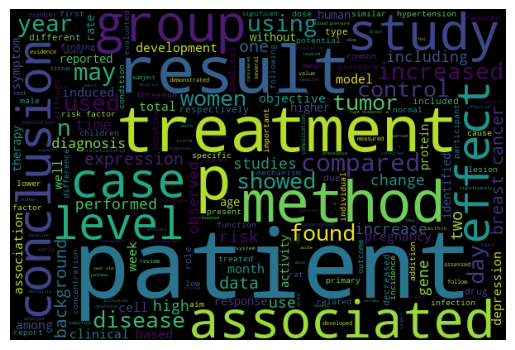

In [76]:
utils.visualize(data, 'control')

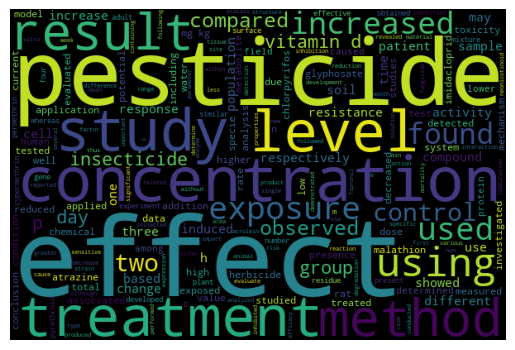

In [77]:
#run this to relad the utils module after changes during session
# from importlib import reload 
# reload(utils);
utils.visualize(data, 'pesticide')

## Create train and test data


In [78]:
x_train, x_test, y_train, y_test = train_test_split(data[data_selection], data[label_selection], random_state=123)

In [79]:
x_train.shape

(6832,)

In [80]:
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# Note the use of different functions for train and test data !

x_train_vec.shape # is a sparse matrix!

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(6832, 2500)

In [81]:
# data must not be sparse matrix before passing into tensorflow
x_train_vec = x_train_vec.toarray()
x_test_vec = x_test_vec.toarray()
x_train_vec.shape

(6832, 2500)

In [82]:
#run this to reload the utils module after changes during session
# from importlib import reload 
# reload(utils)
#utils.plot_top_words(lda, feature_names, n_components = n_components, n_top_words=10);

In [83]:
# number of columns from input dimensions required to specify in the model
print(x_train_vec.shape)
D = x_train_vec.shape[1]

(6832, 2500)


In [84]:
# build model
i = Input(shape=(D,))
# Dense layer with D inputs and one output; no sigmoid here because included in loss
x = Dense(1)(i) 
model = Model(i, x)

In [85]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         2,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True), # different from regression
  optimizer=Adam(learning_rate=0.01), # much lower learning rate
  metrics=['accuracy']            # different from regression; will have two metrics: accuracy and loss
)

In [87]:
r = model.fit(
  x_train_vec, y_train,
  #validation data only with classification!
  validation_data=(x_test_vec, y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5502 - loss: 0.6108 - val_accuracy: 0.8161 - val_loss: 0.4403
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.3982 - val_accuracy: 0.8714 - val_loss: 0.3425
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.3022 - val_accuracy: 0.8815 - val_loss: 0.2952
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9143 - loss: 0.2594 - val_accuracy: 0.8920 - val_loss: 0.2668
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9186 - loss: 0.2369 - val_accuracy: 0.8951 - val_loss: 0.2478
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.2130 - val_accuracy: 0.8990 - val_loss: 0.2340
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9356 - loss: 0.1943 - val_accuracy: 0.9021 - val_loss: 0.2233
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9360 - loss: 0.1871 - val_accuracy: 0.9056 - val_loss:

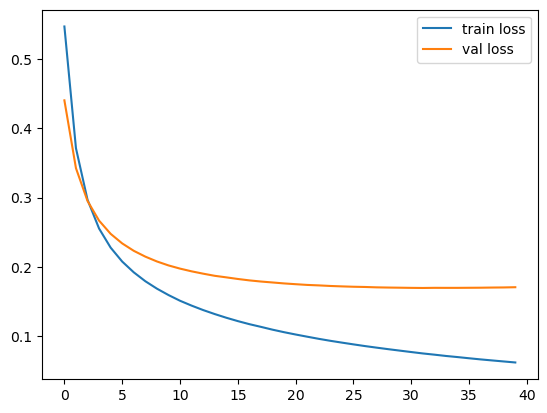

In [88]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

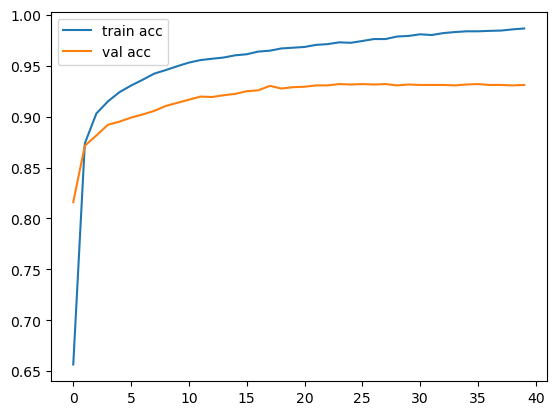

In [89]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [90]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
P_train = ((model.predict(x_train_vec) > 0) * 1.0).flatten()
P_test = ((model.predict(x_test_vec) > 0) * 1.0).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


In [91]:
cm_train = confusion_matrix(y_train, P_train, normalize='true')
cm_train

array([[0.9906401 , 0.0093599 ],
       [0.01136364, 0.98863636]])

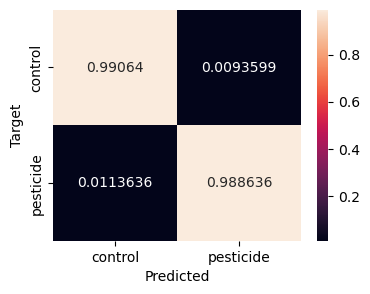

In [92]:
utils.plot_confusion_matrix(cm_train, ['control', 'pesticide'])

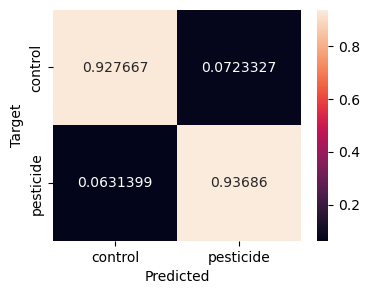

In [93]:
cm_test = confusion_matrix(y_test, P_test, normalize='true')
utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])

In [94]:
Pr_train = model.predict(x_train_vec)
Pr_test = model.predict(x_test_vec)
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
Train AUC: 0.9992871994400527
Test AUC: 0.9819546192348284


In [95]:
print("Train F1:", f1_score(y_train, P_train))
print("Test F1:", f1_score(y_test, P_test))

Train F1: 0.9899018631773574
Test F1: 0.934468085106383


In [96]:
model.layers

[<InputLayer name=input_layer_14, built=True>,
 <Dense name=dense_14, built=True>]

In [97]:
model.layers[1].get_weights()
# word weights and bias

[array([[-0.36051506],
        [ 0.47485724],
        [-3.3044782 ],
        ...,
        [ 0.08790272],
        [ 1.9765412 ],
        [ 0.2990031 ]], dtype=float32),
 array([0.30505753], dtype=float32)]

In [98]:
# store the weights
weights = model.layers[1].get_weights()[0]

In [99]:
word_index_map = vectorizer.vocabulary_
#word_index_map

Gives:
```
{'treated': 1895,
 'available': 183,
 'commercial': 339,
 'form': 744,
 'resulting': 1597,
 'tissue': 1864,
 'change': 285,
 'compared': 345,
 'control': 399,
 'group': 807,
 'examination': 661,
 'utilized': 1932,
 'insect': 950,
 'fat': 710,
 ...
```

In [100]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 4

print("terms in favor of pesticide:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1]) # sort reverse by weight
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)

terms in favor of pesticide:

cholecalciferol 9.880843
acrolein 8.477583
benzalkonium 8.317492
azobenzene 7.804743
chloride 7.794285
chloralose 7.4925814
polyacrylonitrile 7.222636
acrylonitrile 7.1712136
permethrin 7.071904
herbicide 6.397738
vitamin 6.281669
chlorpyrifos 6.1869607
glyphosate 6.119997
calcitriol 6.0062933
femoral 5.921649
pesticide 5.906997
chemical 5.8626204
malathion 5.8515263
cypermethrin 5.7447386
tetraethylammonium 5.737568


In [101]:
print("Terms in favor of control:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1]) # sort by weight
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)


Terms in favor of control:

depression -7.1694546
neurodegenerative -6.88775
hypertension -6.606546
adenocarcinoma -6.223244
osteosarcoma -5.8008537
parkinson -5.7202516
anemia -5.647564
fertility -5.534215
switching -5.4587054
fatigue -5.4096355
infarction -5.3897552
fever -5.3675547
asthma -5.2782397
hepatitis -5.2248316
imbalance -5.203667
breast -5.1838818
cirrhosis -5.162524
delivered -5.082418
hypertensive -5.0780745
pregnancy -5.067724


### Experiment on different batch sizes

In [102]:
def get_model():
    i = Input(shape=(D,))
    x = Dense(1)(i) 
    model = Model(i, x)
    return model

def compile_model(model, learning_rate=0.01):
    model.compile(
        loss=BinaryCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    # no return value needed; model is modified in-place

def fit_model(model, batch_size=128, epochs=40):
    r = model.fit(
        x_train_vec, y_train,
        validation_data=(x_test_vec, y_test),
        epochs=epochs,
        batch_size=batch_size,
    )
    return r

Batch size: 64
Epoch 1/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6021 - loss: 0.5751 - val_accuracy: 0.8600 - val_loss: 0.3712
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8913 - loss: 0.3276 - val_accuracy: 0.8885 - val_loss: 0.2874
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9128 - loss: 0.2545 - val_accuracy: 0.8960 - val_loss: 0.2491
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9337 - loss: 0.2125 - val_accuracy: 0.9039 - val_loss: 0.2274
Epoch 5/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9372 - loss: 0.1898 - val_accuracy: 0.9104 - val_loss: 0.2129
Epoch 6/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.1692 - val_accuracy: 0.9140 - val_loss: 0.2026
Epoch 7/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9504 - loss: 0.1570 - val_accuracy: 0.9197 - val_loss: 0.1946
Epoch 8/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9537 - loss: 0.1477 - v

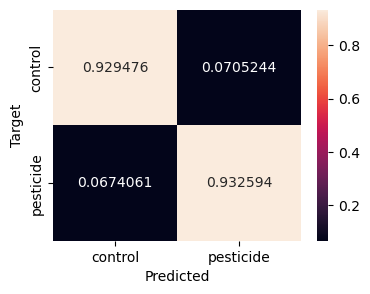

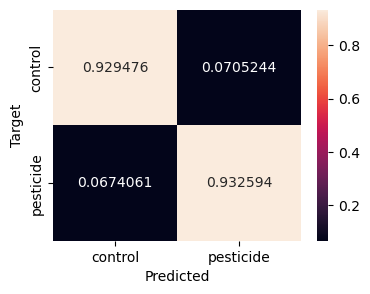

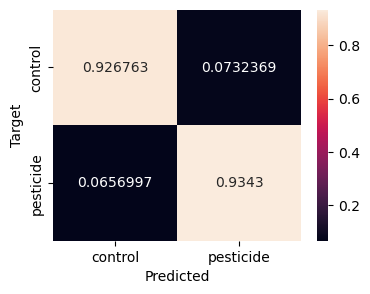

In [69]:
model_results = []
accuracy_scores = []
for batch_size in [64, 128, 256]:
    print("Batch size:", batch_size)
    model = get_model()
    compile_model(model, learning_rate=0.01)
    r = fit_model(model, batch_size=batch_size, epochs=40)
    model_results.append(r)

    P_test = ((model.predict(x_test_vec) > 0) * 1.0).flatten()
    cm_test = confusion_matrix(y_test, P_test, normalize='true')
    print(cm_test)
    utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])
    accuracy_scores.append(accuracy_score(y_test, P_test))


In [70]:
accuracy_scores

[0.931079894644425, 0.931079894644425, 0.9306409130816505]

## Try with extra hidden layers

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5012 - loss: 0.6421 - val_accuracy: 0.7371 - val_loss: 0.5178
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7886 - loss: 0.4772 - val_accuracy: 0.8363 - val_loss: 0.4172
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8755 - loss: 0.3827 - val_accuracy: 0.8652 - val_loss: 0.3588
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8921 - loss: 0.3299 - val_accuracy: 0.8762 - val_loss: 0.3221
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9055 - loss: 0.2948 - val_accuracy: 0.8841 - val_loss: 0.2969
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9172 - loss: 0.2634 - val_accuracy: 0.8876 - val_loss: 0.2785
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9216 - loss: 0.2437 - val_accuracy: 0.8907 - val_loss: 0.2641
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9261 - loss: 0.2278 - val_accuracy: 0.8933 - val_loss:

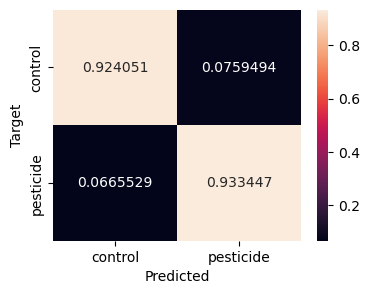

In [ ]:
i = Input(shape=(D,))
x = Dense(128)(i)
x = Dense(64)(i)
x = Dense(1)(i) 
model = Model(i, x)

compile_model(model, learning_rate=0.01)
r = fit_model(model, batch_size=batch_size, epochs=40)

P_test = ((model.predict(x_test_vec) > 0) * 1.0).flatten()
cm_test = confusion_matrix(y_test, P_test, normalize='true')
print(cm_test)
utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])
accuracy_scores.append(accuracy_score(y_test, P_test))


### TODO: how can this information be turned into use cases?